In [15]:
import pandas as pd
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import os

In [2]:
# os.chdir('C:/Users/HK/Desktop/GitHub/Big-Contest')

### 데이터 준비

In [3]:
data = pd.read_csv('preprocess/train_sequence.csv')
labels = pd.read_csv('model/train_label_surv.csv')

In [4]:
print(data.shape)
data.head()

(1120000, 23)


,day,acc_id,week,risk_ratio,char_cnt_act,playtime,total_exp,party_exp_per,fishing,private_shop,...,amount_spent,purchase_pr,purchase_ex,sum_level,combat_cnt,num_opponent,play_char_cnt_pld,pledge_combat_cnt_pld,combat_play_time_pld,first_week
0,1,2,1,0.000000,0.459885,1.251604,0.0,0.0,0.0,2.149331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2,2,1,1.037037,0.459885,1.557190,0.0,0.0,0.0,2.748687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,3,2,1,1.037037,0.459885,1.560441,0.0,0.0,0.0,2.778651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4,2,1,1.037037,0.459885,1.560441,0.0,0.0,0.0,2.733738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,5,2,1,1.037037,0.459885,1.560441,0.0,0.0,0.0,2.736973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
labels.head()

,acc_id,first_week,survival_time,churn,survival_prob,amount_spent,payment
0,2.0,1,64,0,0.549900,0.000000,0
1,5.0,2,60,1,0.558375,0.000000,0
2,8.0,1,64,0,0.549900,0.020310,1
3,17.0,1,64,0,0.549900,0.070642,1
4,20.0,1,64,0,0.549900,0.052137,1


In [6]:
def min_max_scale(xdata):
    minim = np.min(xdata, axis = 0)
    maxim = np.max(xdata, axis = 0)
    xdata = (xdata - minim) / (maxim - minim)
    xdata = np.array(xdata)
    return xdata

In [7]:
xdata = min_max_scale(data.query('first_week == 4 and day > 21').iloc[:, 3:22])
ydata = np.array(labels.query('first_week == 4').iloc[:, 3])

In [8]:
print(xdata.shape)

(12264, 19)


In [9]:
timesteps = 7
nobs = len(xdata) // timesteps
input_features = 19

In [10]:
xdata = xdata.reshape((nobs, timesteps, input_features))
print(xdata.shape)
print(ydata.shape)

(1752, 7, 19)
(1752,)


### 모델링

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size = 0.2, random_state = 100)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size = 3/8, random_state = 200)

In [13]:
print(xtrain.shape)
print(xval.shape)
print(xtest.shape)

(875, 7, 19)
(526, 7, 19)
(351, 7, 19)


In [14]:
from keras.layers import Input, GRU, Dense
from keras.models import Sequential, Model, load_model
from keras import optimizers
from keras import initializers

In [29]:
def define_model_1(hidden_features):
    K.clear_session()
    inputs = Input(shape = (timesteps, input_features))
    
    h = GRU(units = hidden_features)(inputs)
    
    outputs = Dense(units = 1, activation = 'sigmoid')(h)
    model = Model(inputs, outputs)
    return model

In [30]:
model1 = define_model_1(hidden_features = 64)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 19)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                16128     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,193
Trainable params: 16,193
Non-trainable params: 0
_________________________________________________________________


In [31]:
model1.compile(loss = 'binary_crossentropy',
               optimizer = optimizers.adam(lr = 0.001),
               metrics = ['acc'])

In [33]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [34]:
checkpoint = ModelCheckpoint('model/churn_rnn_group3_1.hdf5', save_best_only = True)
earlystopping = EarlyStopping(patience = 50)

history1 = model1.fit(xtrain, ytrain, validation_data = (xval, yval),
                      epochs = 1000, batch_size = 128, 
                      callbacks = [checkpoint, earlystopping], verbose = 2)

Train on 875 samples, validate on 526 samples
Epoch 1/1000
 - 1s - loss: 0.6666 - acc: 0.8057 - val_loss: 0.6328 - val_acc: 0.8783
Epoch 2/1000
 - 0s - loss: 0.6071 - acc: 0.8754 - val_loss: 0.5744 - val_acc: 0.8745
Epoch 3/1000
 - 0s - loss: 0.5482 - acc: 0.8743 - val_loss: 0.5104 - val_acc: 0.8745
Epoch 4/1000
 - 0s - loss: 0.4828 - acc: 0.8743 - val_loss: 0.4432 - val_acc: 0.8745
Epoch 5/1000
 - 0s - loss: 0.4228 - acc: 0.8743 - val_loss: 0.3997 - val_acc: 0.8745
Epoch 6/1000
 - 0s - loss: 0.3950 - acc: 0.8743 - val_loss: 0.3834 - val_acc: 0.8745
Epoch 7/1000
 - 0s - loss: 0.3746 - acc: 0.8777 - val_loss: 0.3596 - val_acc: 0.8859
Epoch 8/1000
 - 0s - loss: 0.3545 - acc: 0.8823 - val_loss: 0.3462 - val_acc: 0.8859
Epoch 9/1000
 - 0s - loss: 0.3429 - acc: 0.8834 - val_loss: 0.3354 - val_acc: 0.8859
Epoch 10/1000
 - 0s - loss: 0.3333 - acc: 0.8857 - val_loss: 0.3290 - val_acc: 0.8840
Epoch 11/1000
 - 0s - loss: 0.3280 - acc: 0.8869 - val_loss: 0.3253 - val_acc: 0.8745
Epoch 12/1000
 - 

In [35]:
def history_plot(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)
    
    minim = np.argmin(val_loss)
    plt.plot(epochs, loss, 'k', label = 'Training')
    plt.plot(epochs, val_loss, 'r', label = 'Valdiation')
    plt.axvline(minim, color = 'gray', linestyle = ':')
    plt.legend()
    plt.title('Loss (Cross Entropy)')
    plt.show()
    
    plt.plot(epochs, acc, 'k', label = 'Training')
    plt.plot(epochs, val_acc, 'r', label = 'Valdiation')
    plt.axvline(minim, color = 'gray', linestyle = ':')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

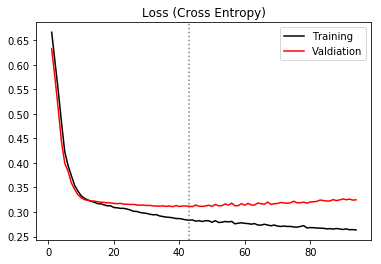

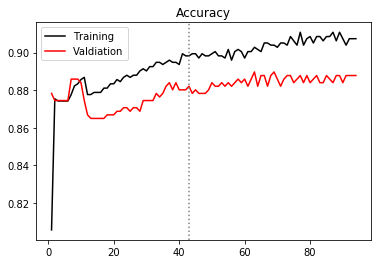

In [36]:
history_plot(history1)

### 모델 평가

In [16]:
best1 = load_model('model/churn_rnn_group3_1.hdf5')

In [17]:
pred1 = best1.predict(xval)
pred1 = pred1.reshape(len(pred1))

In [18]:
prob_seq = np.arange(0, 1, step = 0.05)

In [19]:
def ischurn(pred, prob):
    churn = np.array([1 if pred[i] > prob else 0 for i in range(len(pred))])
    return churn 

In [20]:
from sklearn.metrics import confusion_matrix, f1_score

In [21]:
def f1score(pred, true, prob_seq):
    error = []
    for p in prob_seq:
        c = ischurn(pred, p)
        e = f1_score(true, c)
        error.append(e)
    return np.array(error)

In [22]:
score1 = f1score(pred1, yval, prob_seq)

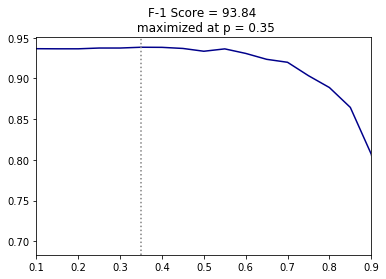

In [24]:
max_score1 = np.round(np.max(score1)*100, 2)
prob_best1 = np.round(prob_seq[np.argmax(score1)], 2)

plt.plot(prob_seq, score1, c = 'darkblue')
plt.axvline(prob_best1, color = 'gray', linestyle = ':')
plt.xlim(0.1, 0.9)
plt.title('F-1 Score = {} \n maximized at p = {}'.format(max_score1, prob_best1))
plt.show()

In [26]:
pred1 = best1.predict(xtest)
pred_churn1 = np.array([1 if p > 0.35 else 0 for p in pred1])

In [27]:
print(confusion_matrix(pred_churn1, ytest))

[[  6   4]
 [ 39 302]]


In [30]:
np.mean(pred_churn1 == ytest)

0.8774928774928775